# Tuto: convolve template to spike

author: steeve.laquitaine@epfl.ch


1. We want the spike and universal template projection coordinates to only depend on their shapes, which we define as their voltage change over time. A template and a spike with identical voltage dynamic have identical shapes, irrespective of the magnitude or timing of their peak, as one can align and scale the template to perfectly fit the spike. Pachitariu 2023 actually do something similar during template matching. That means that each spike will be associated with a best fit template.

2. Because W has the unit norm (norm=1), W^T.D, the projection of vector D on vector W (the best fit of W to D) has norm x, which is also the best matching amplitude that the template needs to be multiplied by to match the data.

3. The spikes D should be unit-normed if we instead want to fix a universal template and fit all spikes to that template (a form of spike normalization).

4. We might be able to decompose Pachitariu 2023's template deconvolution (template fitting) into a sequence of spike alignment with a fixed template by maximizing their cross-correlation, then a projection (best-fit scaling) of the template-aligned spikes onto the template. Spike alignment with template remains the same after re-scaling templates or spikes. (note: the mathematical calculation of Correlation is same as convolution in time domain, except that the signal is not reversed, before the multiplication process). Temporal convolution consists in sliding the kernel (our template) on the recording and performing the dot product. We could directly apply temporal convolution between template and spikes and use the max energy signal lag to align spikes with the template, the dot product also yields the best fit rescaled template for each spike or vvs.


## Setup

Virtual env is `env_kilosort_silico`

You should have extracted the templates from a KS3 run by running `python3.9 -m src.pipes.postpro.univ_temp` in the terminal before. See usage in `univ_temp` module.


In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.truth.silico import ground_truth
from src.pipes.postpro import univ_temp
from src.nodes.postpro import template_matching as temp_match

# SET DATA PATH 
# whole campaign files
SPIKE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/spiketrains.pkl'
RAW_LFP_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/traces.pkl'
CELL_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/cells/cell_3754013_trace.pkl'


# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"
STUDY_FOLDER = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/sorting/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/study'
EXAMPLE_CELL_ID = 4209594
EXAMPLE_CHANNEL_ID = 20
MS_BEFORE = 3           # ms
MS_AFTER = 3            # ms
CELL_TYPE = "PYR"
LOAD_WAVEFORM_EXTRACTOR = False
LOAD_GROUND_TRUTH = True
LOAD_PREP_TRACE = True


# SET CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SET MODEL INPUT DATA PATHS
INSTANCE_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["instances"]
CHANNEL_IDS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["channel_ids"]
CELL_LABELS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["cell_labels"]
SPIKE_STATUS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["spike_status"]
NEAREST_CHANNEL_FILE_PATH  = data_conf["sorting"]["deepnet"]["input"]["nearest_channel"]

# SET PLOT PARAMETERS
cmap = plt.get_cmap("tab20")
colors = cmap(np.linspace(0,1,24))[:,:3]

# set colors for detected 
detected_colors = colors[:12,]
missed_colors = colors[12:,]

2023-05-09 13:00:22,564 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-09 13:00:22,588 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-05-09 13:00:22,591 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-09 13:00:22,614 - root - utils.py - get_config - INFO - Reading experiment config. - done


1. fix a channel
2. find nearby ground truth cells (within 40 microns of the channel)
3. fit the cell spikes and universal templates with tsne and project on a 2D space
4. get seed templates, missed sparse cells , detected sparse cells  


spike dataset engineering was done with '/gpfs/bbp.cscs.ch/data/project/proj68/home/laquitai/spike-sorting/notebooks/2_deepnet/0b_dataeng_neuropix_32.ipynb'

## Load spike snippets

In [ ]:
# load spike data
all_instances = pd.read_pickle(INSTANCE_FILE_PATH)
channel_ids = pd.read_pickle(CHANNEL_IDS_FILE_PATH)
cells = pd.read_pickle(CELL_LABELS_FILE_PATH)
spike_status = pd.read_pickle(SPIKE_STATUS_FILE_PATH)
nearest_channel = pd.read_pickle(NEAREST_CHANNEL_FILE_PATH)

## Check a raw template and ground truth detected cell spikes

spike count: 5
2023-05-09 13:00:37,133 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-09 13:00:37,145 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


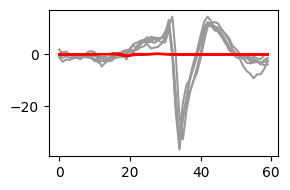

In [3]:
# plot a missed sparse cell
NEAREST_CHANNEL = 30
DETECTED_CELL = 19690

# setup plots
fig, axis = plt.subplots(1,1, figsize=(3,2))

# plot a detected sparse cell
detected_cell_instances = all_instances.iloc[np.where((cells.values==DETECTED_CELL) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()]
axis.plot(detected_cell_instances.T, color=(0.6, 0.6, 0.6));
print("spike count:", detected_cell_instances.shape[0])
Truth = ground_truth.load(data_conf)
assert Truth.get_total_num_spikes()[DETECTED_CELL] == detected_cell_instances.shape[0], "spike count does not make sense"

# plot Kilosort3's six universal templates
templates = univ_temp.load(data_conf)
templates = templates.T[:,:-1]
axis.plot(templates.T, "r");
plt.tight_layout()

### Plot best-fitted template with best-matched signal (the detected spike).

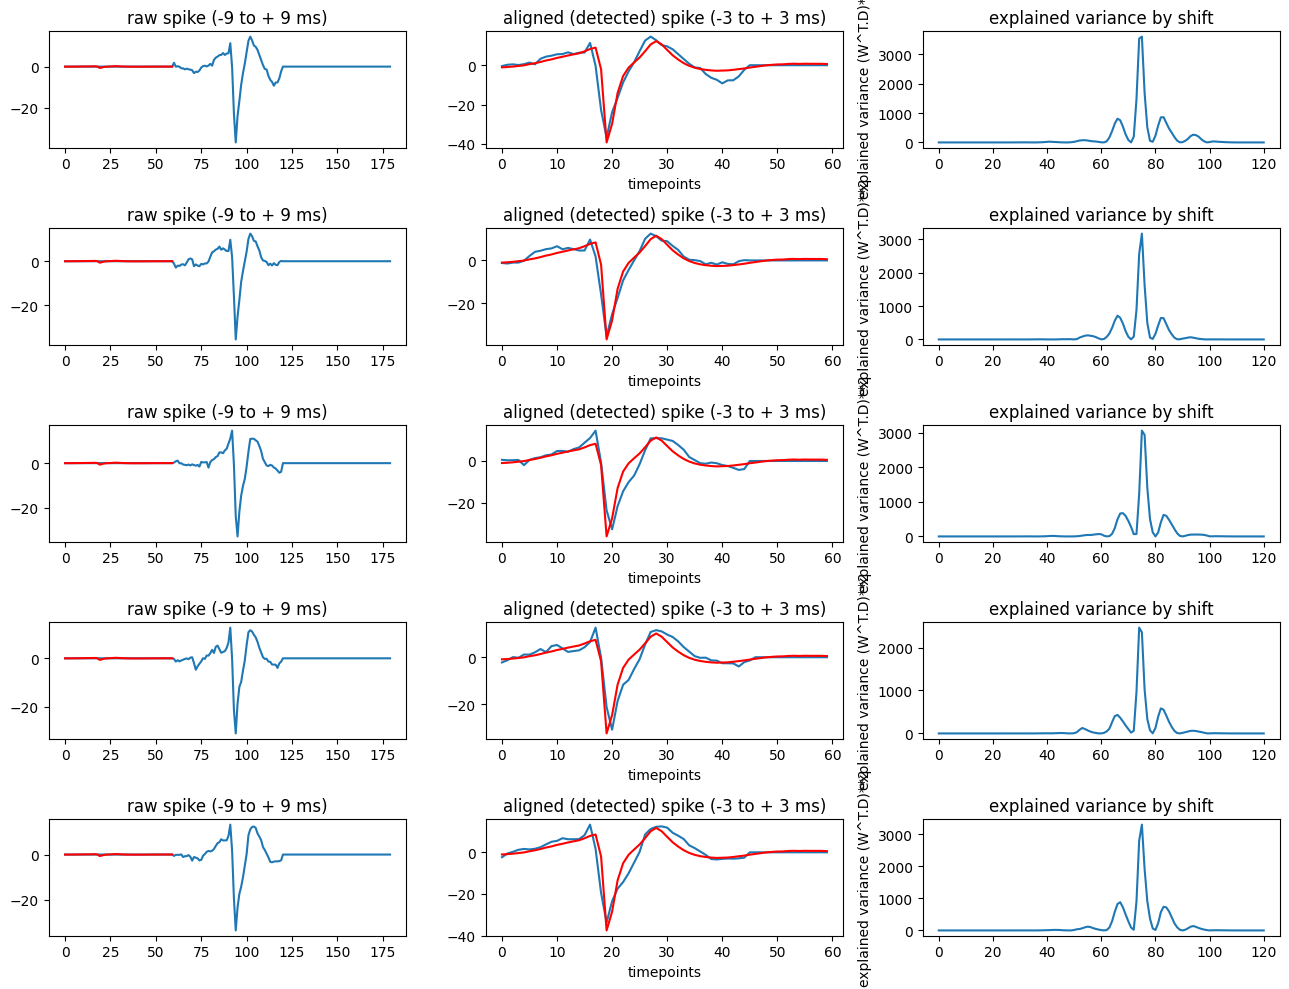

In [6]:
# apply template matching
output = temp_match.template_match_with_padding(detected_cell_instances, templates[0])